# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-8, 1e-7]
regularization_strengths = [5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
import copy
num_LR_tests = 10
num_RS_tests = 10
iters_per_test = 1500
deltaLR = (learning_rates[1]-learning_rates[0])/(num_LR_tests-1)
deltaRS = (regularization_strengths[1]-regularization_strengths[0])/(num_RS_tests-1)
LR = learning_rates[0]
for i in range(num_LR_tests):
    RS = regularization_strengths[0]
    for j in range(num_RS_tests):
        testSVM = LinearSVM()
        testSVM.train(X_train_feats, y_train, learning_rate=LR, reg=RS, num_iters=iters_per_test, verbose=True)
        y_train_pred = testSVM.predict(X_train_feats)
        y_val_pred = testSVM.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = copy.deepcopy(testSVM)
        results[(LR, RS)] = (np.mean(y_train == y_train_pred), val_acc)
        RS += deltaRS
    LR += deltaLR
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 401.999757
iteration 100 / 1500: loss 10.013647
iteration 200 / 1500: loss 9.999938
iteration 300 / 1500: loss 9.999946
iteration 400 / 1500: loss 9.999933
iteration 500 / 1500: loss 9.999926
iteration 600 / 1500: loss 9.999932
iteration 700 / 1500: loss 9.999925
iteration 800 / 1500: loss 9.999942
iteration 900 / 1500: loss 9.999932
iteration 1000 / 1500: loss 9.999926
iteration 1100 / 1500: loss 9.999941
iteration 1200 / 1500: loss 9.999915
iteration 1300 / 1500: loss 9.999937
iteration 1400 / 1500: loss 9.999938
iteration 0 / 1500: loss 784.104233
iteration 100 / 1500: loss 9.999959
iteration 200 / 1500: loss 9.999971
iteration 300 / 1500: loss 9.999977
iteration 400 / 1500: loss 9.999969
iteration 500 / 1500: loss 9.999965
iteration 600 / 1500: loss 9.999967
iteration 700 / 1500: loss 9.999964
iteration 800 / 1500: loss 9.999963
iteration 900 / 1500: loss 9.999969
iteration 1000 / 1500: loss 9.999959
iteration 1100 / 1500: loss 9.999958
iteration 1200 / 150

iteration 500 / 1500: loss 9.999990
iteration 600 / 1500: loss 9.999991
iteration 700 / 1500: loss 9.999994
iteration 800 / 1500: loss 9.999992
iteration 900 / 1500: loss 9.999994
iteration 1000 / 1500: loss 9.999990
iteration 1100 / 1500: loss 9.999994
iteration 1200 / 1500: loss 9.999993
iteration 1300 / 1500: loss 9.999994
iteration 1400 / 1500: loss 9.999992
iteration 0 / 1500: loss 2661.297937
iteration 100 / 1500: loss 9.999993
iteration 200 / 1500: loss 9.999996
iteration 300 / 1500: loss 9.999994
iteration 400 / 1500: loss 9.999995
iteration 500 / 1500: loss 9.999996
iteration 600 / 1500: loss 9.999992
iteration 700 / 1500: loss 9.999996
iteration 800 / 1500: loss 9.999996
iteration 900 / 1500: loss 9.999995
iteration 1000 / 1500: loss 9.999997
iteration 1100 / 1500: loss 9.999997
iteration 1200 / 1500: loss 9.999997
iteration 1300 / 1500: loss 9.999995
iteration 1400 / 1500: loss 9.999996
iteration 0 / 1500: loss 3033.807611
iteration 100 / 1500: loss 9.999997
iteration 200 / 

iteration 500 / 1500: loss 9.999937
iteration 600 / 1500: loss 9.999952
iteration 700 / 1500: loss 9.999948
iteration 800 / 1500: loss 9.999944
iteration 900 / 1500: loss 9.999937
iteration 1000 / 1500: loss 9.999945
iteration 1100 / 1500: loss 9.999929
iteration 1200 / 1500: loss 9.999944
iteration 1300 / 1500: loss 9.999928
iteration 1400 / 1500: loss 9.999944
iteration 0 / 1500: loss 778.854694
iteration 100 / 1500: loss 9.999981
iteration 200 / 1500: loss 9.999968
iteration 300 / 1500: loss 9.999986
iteration 400 / 1500: loss 9.999976
iteration 500 / 1500: loss 9.999973
iteration 600 / 1500: loss 9.999970
iteration 700 / 1500: loss 9.999975
iteration 800 / 1500: loss 9.999978
iteration 900 / 1500: loss 9.999969
iteration 1000 / 1500: loss 9.999990
iteration 1100 / 1500: loss 9.999978
iteration 1200 / 1500: loss 9.999969
iteration 1300 / 1500: loss 9.999977
iteration 1400 / 1500: loss 9.999972
iteration 0 / 1500: loss 1162.696765
iteration 100 / 1500: loss 9.999987
iteration 200 / 1

iteration 1300 / 1500: loss 10.000025
iteration 1400 / 1500: loss 10.000026
iteration 0 / 1500: loss 2853.562929
iteration 100 / 1500: loss 10.000059
iteration 200 / 1500: loss 10.000061
iteration 300 / 1500: loss 10.000051
iteration 400 / 1500: loss 10.000056
iteration 500 / 1500: loss 10.000061
iteration 600 / 1500: loss 10.000054
iteration 700 / 1500: loss 10.000054
iteration 800 / 1500: loss 10.000056
iteration 900 / 1500: loss 10.000059
iteration 1000 / 1500: loss 10.000057
iteration 1100 / 1500: loss 10.000060
iteration 1200 / 1500: loss 10.000061
iteration 1300 / 1500: loss 10.000063
iteration 1400 / 1500: loss 10.000060
iteration 0 / 1500: loss 2978.060166
iteration 100 / 1500: loss 2978.010141
iteration 200 / 1500: loss 2977.798627
iteration 300 / 1500: loss 2977.825353
iteration 400 / 1500: loss 2977.715507
iteration 500 / 1500: loss 2977.509753
iteration 600 / 1500: loss 2977.429991
iteration 700 / 1500: loss 2977.488719
iteration 800 / 1500: loss 2977.643096
iteration 900 /

/home/fowsley/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: overflow encountered in double_scalars
  loss = np.sum(np.maximum(0, scores-correct_class_scores+1)) / X.shape[0] + reg * .5 * np.sum(W * W)
/home/fowsley/anaconda3/envs/cs231n/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/fowsley/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: overflow encountered in multiply
  loss = np.sum(np.maximum(0, scores-correct_class_scores+1)) / X.shape[0] + reg * .5 * np.sum(W * W)


iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
iteration 0 / 1500: loss 385.966873
iteration 100 / 1500: loss 9.999939
iteration 200 / 1500: loss 9.999925
iteration 300 / 1500: loss 9.999938
iteration 400 / 1500: loss 9.999944
iteration 500 / 1500: loss 9.999951
iteration 600 / 1500: loss 9.999944
iteration 700 / 1500: loss 9.999938
iteration 800 / 1500: loss 9.999943
iteration 900 / 1500: loss 9.999938
iteration 1000 / 1500: loss 9.999940
iteration 1100 / 1500: loss 9.999938
iteration 1200 / 1500: loss 9.999945
iteration 1300 / 1500: loss 9.999949
iteration 1400 / 1500: loss 9.999916
iteration 0 / 1500: loss 765.708825
iteration 100 / 1500: loss 9.999976
iteration 200 / 1500: loss 9.999986
iteration 300 / 1500: loss 9.999974
iteration 400 / 1500: loss 9.999984
iteration 500 / 1500: loss 9.999980
iteration 600 / 1500: loss 9.999988
iteration 700 / 1500: loss 9.999983
iteration 800 / 1500: loss 9.999978
ite

/home/fowsley/assignment1/cs231n/classifiers/linear_svm.py:98: RuntimeWarning: overflow encountered in multiply
  dW += reg * W
/home/fowsley/assignment1/cs231n/classifiers/linear_svm.py:77: RuntimeWarning: invalid value encountered in subtract
  loss = np.sum(np.maximum(0, scores-correct_class_scores+1)) / X.shape[0] + reg * .5 * np.sum(W * W)
/home/fowsley/assignment1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: invalid value encountered in subtract
  passed = np.maximum(0, scores - correct_class_scores + 1)
/home/fowsley/assignment1/cs231n/classifiers/linear_classifier.py:70: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 0 / 1500: loss 3899.355007
iteration 100 / 1500: loss 6249952741837341981832545503364001872374214651197525114381926400.000000
iteration 200 / 1500: loss 10043286835679212273177768876860152479911012636420815994183322881005824090860791405839662177317500255175747968289311450726400.000000
iteration 300 / 1500: loss 16138939705658416406640597329126575772135204025177712235629833858154034042171519231240039420147549603869702675273020864755606614328348251475041725214847075817824534518440993118119526400.000000
iteration 400 / 1500: loss 25934276207024499833948135935325146293208894744680491736020069815822512135969008934779248727185378377130703900850091686869453954207200478297921718781521716657021709835516482788512012471335872099938764053041243303724583716000461881479734388326400.000000
iteration 500 / 1500: loss 416747750873884141640815690976018113406285037463177050928293224485241318797518857814168749243701313105343913982138688287323487406266618833517836266559221556881081314186816570238

iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3701.079880
iteration 100 / 1500: loss 11346082581332552901467394555067511411276904912290451714954885179899904.000000
iteration 200 / 1500: loss 34876903790920379510727573731439363862143773400979492471252037215939264271338919196016981613315694183682614042278636266630176063965102080.000000
iteration 300 / 1500: loss 107208669540483373137624120426078592764103631913786698590656308565859064079552077671419461404489380067088287792461323014511643383699954168572202010431903793925468324755698813200593391877758151664745840640.000000
iteration 400 / 1500: loss 329550435254885359057079485734034468608836659311117517451046696743822767090321692455961791663103942414684056948481282983045693922448448962092579597575326192658530860606158505594209228729279233796239970906999728789051886912725074961927111567974641264453499711227107999744.000000
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 /

iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 3047.685971
iteration 100 / 1500: loss 926996768358555164198869490507489232273381584617562221503838628744265728.000000
iteration 200 / 1500: loss 282887908373558591492494634111082571998642537686212753800879394290513578765752976765009177252250366653718116482863005986869733813109450080256.000000
iteration 300 / 1500: loss 86327775279809368252020447312214085764658149511717844464710420084935131573519722231410519064082097057364155393092865686063601078958421611586345237398970569376259942967995464010889220381948033322151129244499968.000000
iteration 400 / 1500: loss 26344303040765288292113037383066423903213936205982544512705562808928495452409383089422928486575592346371179738282913933927781376786559335411016007332188489354522380714723876173854438391297552577139925272614229280958003344709608953526234877299845602725481334270621253034798219264.000000
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss i

iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2464.164282
iteration 100 / 1500: loss 7543914048384585024650566004501014319608491321152268915033894973079552.000000
iteration 200 / 1500: loss 23189357435611124140519703629283511478059766380041567258040313643400135346915289575512090399702694939033945850726527067902971539521273856.000000
iteration 300 / 1500: loss 71282134821205077156373877567775557463205689601926234812486303870081280839842437233551524871907360740733965084089496474517730906194708385050782042081683721156437061717100399897626754905813088080783998976.000000
iteration 400 / 1500: loss 219115288501505223543978684069390348791374768181216040734325071326743402999129797800714636349763461469975540022481646098768509440897408166091603817272301382868907027089

iteration 500 / 1500: loss 23613533726459572404532854810433090450924343763420865500392315193543107673825819684624392875074600072528120156199982987458722277619476998041329458536956178853472399700072175980893363827042757497134391857102549060513692131400234158206000777690681802790886927888340545408547845387932515732792289912978145280.000000
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
iteration 0 / 1500: loss 2781.472556
iteration 100 / 1500: loss 107328470788621512417695557592293130312861099553452548325940781298669629176885018624.000000
iteration 200 / 1500: loss 4156393682091516423555714512525064565396833226725998128650074075325339391383941729761491210036537925018440805193860551454990359973267893162827560107667699330449408.000000
iteration 300 / 1500: 

In [14]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.413


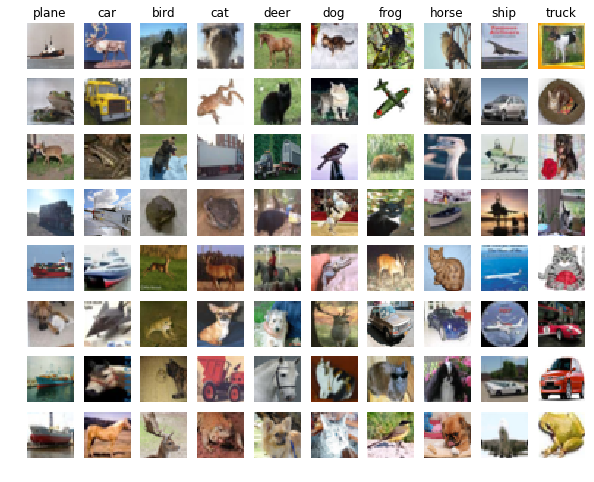

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense? 
Some of the misclassifications make sense; some do not. Often they have the same overall body shape as the object they are misclassified as, but the smaller details are the same. In many of them the shape is very different however, but the overall color is the same. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

iteration 0 / 4000: loss 2.302585
iteration 100 / 4000: loss 1.488217
iteration 200 / 4000: loss 1.580358
iteration 300 / 4000: loss 1.420915
iteration 400 / 4000: loss 1.214140
iteration 500 / 4000: loss 1.219011
iteration 600 / 4000: loss 1.323923
iteration 700 / 4000: loss 1.103240
iteration 800 / 4000: loss 1.055222
iteration 900 / 4000: loss 1.191492
iteration 1000 / 4000: loss 1.032689
iteration 1100 / 4000: loss 1.062414
iteration 1200 / 4000: loss 1.040154
iteration 1300 / 4000: loss 1.033788
iteration 1400 / 4000: loss 1.007307
iteration 1500 / 4000: loss 1.008750
iteration 1600 / 4000: loss 1.095867
iteration 1700 / 4000: loss 1.279079
iteration 1800 / 4000: loss 1.052907
iteration 1900 / 4000: loss 1.129658
iteration 2000 / 4000: loss 0.977043
iteration 2100 / 4000: loss 1.044765
iteration 2200 / 4000: loss 1.048479
iteration 2300 / 4000: loss 0.999411
iteration 2400 / 4000: loss 0.884426
iteration 2500 / 4000: loss 0.838582
iteration 2600 / 4000: loss 0.939733
iteration 270

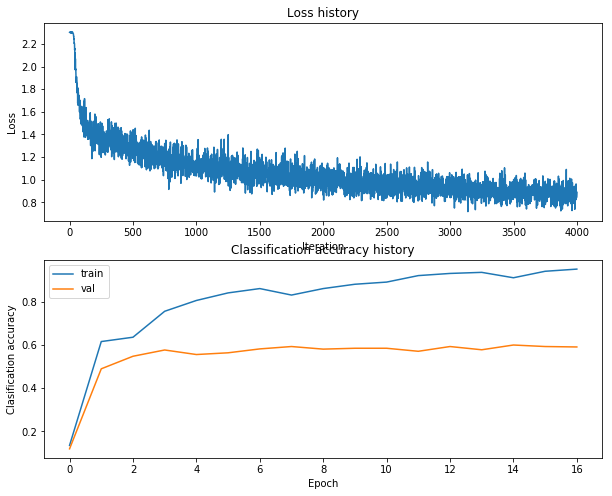

In [54]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
input_size = 32 * 32 * 3
hidden_size = 100
num_classes = 10
best_net = TwoLayerNet(input_dim, hidden_dim, num_classes)

stats = best_net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=4000, batch_size=200,
            learning_rate=5e-1, learning_rate_decay=0.97,
            reg=.0005, #.4 
            verbose=True)

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [58]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.583
